In [48]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from keras import layers

import torch
import torch.nn as nn
import torch.nn.functional as F

In [49]:
IMG_SIZE = 32
BATCH_SIZE = 32
DATA_DIR = "../data"

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.3),
    layers.RandomBrightness(0.2),
])


train_ds = keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

val_ds = keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
test_ds = keras.preprocessing.image_dataset_from_directory(
    DATA_DIR + "/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 3206 files belonging to 3 classes.
Using 2565 files for training.
Found 3206 files belonging to 3 classes.
Using 641 files for validation.
Found 363 files belonging to 2 classes.


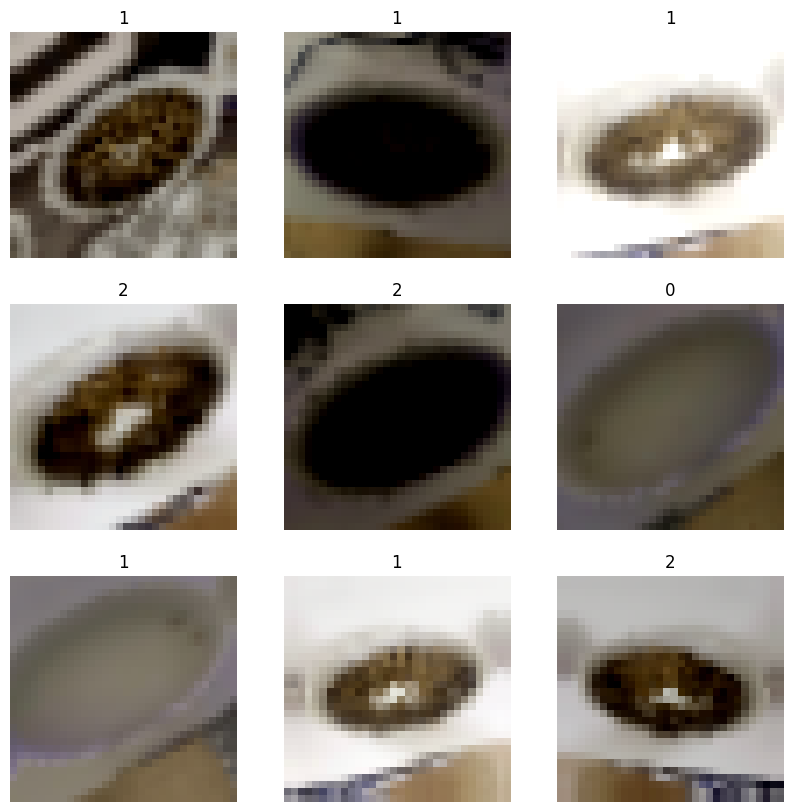

In [50]:
images, labels = next(iter(train_ds))

plt.figure(figsize=(10, 10))

for i in range(9):  
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(str(labels[i].numpy()))
    plt.axis("off")

plt.show()

In [51]:
IMG_SIZE = 32

model = keras.Sequential([
    keras.layers.Rescaling(1/255.0, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    keras.layers.Conv2D(8, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(8, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])


model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)


C:\Users\silva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [52]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6573 - loss: -2.8372 - val_accuracy: 0.6490 - val_loss: -17.1582
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6647 - loss: -256.5422 - val_accuracy: 0.6490 - val_loss: -984.6846
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6647 - loss: -4073.2104 - val_accuracy: 0.6490 - val_loss: -9855.3838
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6647 - loss: -22160.0859 - val_accuracy: 0.6490 - val_loss: -44671.1602
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6647 - loss: -82217.8672 - val_accuracy: 0.6490 - val_loss: -142097.2344
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6647 - loss: -225774.4375 - val_accuracy: 0.6490 - val_loss: -363032.0625
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6647 - loss: -538041.5000 - val_accuracy: 0.6490 - val_loss: -822217.6250
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/ste

In [53]:
model.evaluate(test_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4986 - loss: 28266752.0000  


[28266752.0, 0.4986225962638855]

In [ ]:
model.export("saved_model")

# Convert to .tflite (float)
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()

with open("catbowl4.tflite", "wb") as f:
    f.write(tflite_model)

print("Saved catbowl.tflite")

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor_153')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2031377653136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031377658320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031377657168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031377645648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031377655440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031377646032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031377657744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031377646416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031377645840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031377659664: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved catbowl.tflite
